# ELMo Contextual Embeddings

In this notebook, we use contextual embeddings from ELMo to study semantic change of conversion.

In [1]:
import sys
sys.path.append('../')

import numpy as np
import pandas as pd
import allennlp.commands.elmo
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.decomposition
import sklearn.metrics
import tqdm

import src.ud_corpus

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Read the CoNLL-U file

In [2]:
UD_FILE = "../data/en_ewt-ud-train.conllu"

ud = src.ud_corpus.UDCorpus(data_file_path=UD_FILE)
ud.data[:3]

[TokenList<Al, -, Zaman, :, American, forces, killed, Shaikh, Abdullah, al, -, Ani, ,, the, preacher, at, the, mosque, in, the, town, of, Qaim, ,, near, the, Syrian, border, .>,
 TokenList<[, This, killing, of, a, respected, cleric, will, be, causing, us, trouble, for, years, to, come, ., ]>,
 TokenList<DPA, :, Iraqi, authorities, announced, that, they, had, busted, up, 3, terrorist, cells, operating, in, Baghdad, .>]

## Run ELMo on the entire corpus

In [3]:
elmo = allennlp.commands.elmo.ElmoEmbedder(cuda_device=0)
data_as_tokens = [[t['form'] for t in token_list] for token_list in ud.data]

BATCH_SIZE = 64
elmo_embeddings = []
for ix in tqdm.tqdm(range(0, len(data_as_tokens), BATCH_SIZE)):
  batch = data_as_tokens[ix : ix+BATCH_SIZE]
  batch_embeddings = elmo.embed_batch(batch)
  # Only take embeddings from last ELMo layer
  batch_embeddings = [x[-1] for x in batch_embeddings]
  elmo_embeddings.extend(batch_embeddings)

100%|██████████| 196/196 [00:28<00:00,  5.58it/s]


## ELMo embeddings of instances of a fixed lemma

In [4]:
def get_elmo_embeddings_for_lemma(lemma):
  noun_embeddings = []
  verb_embeddings = []

  for sentence_ix in range(len(ud.data)):
    token_list = ud.data[sentence_ix]
    embeddings = elmo_embeddings[sentence_ix]
    for i in range(len(token_list)):
      if token_list[i]['lemma'] == lemma:
        if token_list[i]['upostag'] == 'NOUN':
          noun_embeddings.append(embeddings[i])
        elif token_list[i]['upostag'] == 'VERB':
          verb_embeddings.append(embeddings[i])

  noun_embeddings = np.vstack(noun_embeddings)
  verb_embeddings = np.vstack(verb_embeddings)
  return noun_embeddings, verb_embeddings

In [15]:
FIXED_LEMMA = "work"
noun_embeddings, verb_embeddings = get_elmo_embeddings_for_lemma(FIXED_LEMMA)
print("Noun instances:", noun_embeddings.shape[0])
print("Verb instances:", verb_embeddings.shape[0])

Noun instances: 118
Verb instances: 223


## Apply PCA and plot

In [16]:
pca = sklearn.decomposition.PCA(n_components=2)
all_embeddings = pca.fit_transform(np.vstack([noun_embeddings, verb_embeddings]))
all_embeddings_df = pd.DataFrame({'x0': all_embeddings[:,0], 'x1': all_embeddings[:,1]})
all_embeddings_df['pos'] = ['noun'] * len(noun_embeddings) + ['verb'] * len(verb_embeddings)

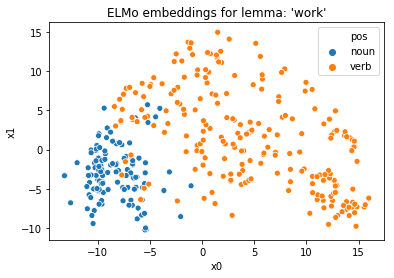

In [17]:
plot = sns.scatterplot(data=all_embeddings_df, x='x0', y='x1', hue='pos')
plot.set(title="ELMo embeddings for lemma: '%s'" % FIXED_LEMMA)
plt.show()

## Cosine similarity between noun and verb usages

In [8]:
lemma_count_df = ud.get_per_lemma_stats()

# Filter: must have at least [x] noun and [x] verb usages
lemma_count_df = lemma_count_df[(lemma_count_df['noun_count'] >= 10) & (lemma_count_df['verb_count'] >= 10)]
lemma_count_df = lemma_count_df.sort_values('total_count', ascending=False)
print('Remaining lemmas:', len(lemma_count_df))

Remaining lemmas: 90


In [9]:
def get_nv_cosine_similarity(row):
  noun_embeddings, verb_embeddings = get_elmo_embeddings_for_lemma(row.lemma)
  
  avg_noun_embedding = np.mean(noun_embeddings, axis=0)
  avg_verb_embedding = np.mean(verb_embeddings, axis=0)

  return float(sklearn.metrics.pairwise.cosine_similarity(avg_noun_embedding[np.newaxis,:], avg_verb_embedding[np.newaxis,:]))

lemma_count_df['nv_cosine_similarity'] = lemma_count_df.apply(get_nv_cosine_similarity, axis=1)

In [10]:
lemma_count_df[['lemma', 'noun_count', 'verb_count', 'majority_tag', 'nv_cosine_similarity']] \
  .sort_values('nv_cosine_similarity').head(8)

,lemma,noun_count,verb_count,majority_tag,nv_cosine_similarity
1020,issue,90,16,NOUN,0.316169
80,back,36,14,NOUN,0.330944
1869,regard,10,42,VERB,0.352570
4544,associate,12,11,NOUN,0.356264
751,base,19,47,VERB,0.371427
1432,train,13,28,VERB,0.373536
2886,bear,21,31,VERB,0.378693
608,state,67,28,NOUN,0.387076


In [11]:
lemma_count_df[['lemma', 'noun_count', 'verb_count', 'majority_tag', 'nv_cosine_similarity']] \
  .sort_values('nv_cosine_similarity', ascending=False).head(8)

,lemma,noun_count,verb_count,majority_tag,nv_cosine_similarity
1075,search,16,12,NOUN,0.823591
3483,matter,17,10,NOUN,0.806312
128,work,118,223,VERB,0.778654
889,care,48,31,NOUN,0.760845
2180,note,29,24,NOUN,0.740294
1043,cut,14,24,VERB,0.736534
509,return,24,55,VERB,0.729375
876,help,49,150,VERB,0.706198


/scratch/gobi1/wgao/anaconda-pkgs/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


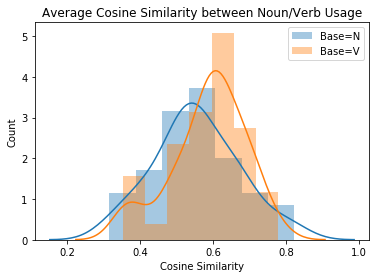

In [12]:
plot = sns.distplot(lemma_count_df[lemma_count_df.majority_tag == 'NOUN'].nv_cosine_similarity, label='Base=N')
plot = sns.distplot(lemma_count_df[lemma_count_df.majority_tag == 'VERB'].nv_cosine_similarity, label='Base=V')
plt.legend()
plot.set(title="Average Cosine Similarity between Noun/Verb Usage",
         xlabel="Cosine Similarity", ylabel="Count")
plt.show()

In [13]:
# T-test of difference in mean
import scipy.stats
scipy.stats.ttest_ind(lemma_count_df[lemma_count_df.majority_tag == 'NOUN'].nv_cosine_similarity,
                      lemma_count_df[lemma_count_df.majority_tag == 'VERB'].nv_cosine_similarity)

Ttest_indResult(statistic=-1.409510963814988, pvalue=0.16220840648872334)